In [21]:
import matplotlib.pyplot as plt
import numpy as np
import importlib
import sys

if '..' not in sys.path:
   sys.path.append('..')

from ehr2vec.binary_tmle import estimators, simulate_data, pipelines, vis
importlib.reload(estimators)
importlib.reload(simulate_data)
importlib.reload(pipelines)
importlib.reload(vis)

from ehr2vec.binary_tmle.estimators import IPW_estimator, AIPW_estimator, TMLE_estimator
from ehr2vec.binary_tmle.vis import display_results
from ehr2vec.binary_tmle.simulate_data import (
    compute_ATE_theoretical_from_data, simulate_binary_data, print_basic_stats)
from ehr2vec.binary_tmle.pipelines import get_scores_for_models_and_estimators

## Simulate binary data and compute theoretical ATE

In [3]:
ALPHA = [0, 0.5, -0.5, 0]
BETA = [-1, 2, 1, -1, 0]

data = simulate_binary_data(10000, alpha=ALPHA, beta=BETA)
ate_th_data = compute_ATE_theoretical_from_data(simulate_binary_data(10000, alpha=ALPHA, beta=BETA), BETA)
# ate_th_model = compute_ATE_theoretical_from_model()
print(f"ATE theoretical from data: {round(ate_th_data, 4)}")
# print(f"from model: {round(ate_th_model, 4)}")

ATE theoretical from data: 0.3504


### Make sure the model is appropriate

In [4]:
print_basic_stats(simulate_binary_data(100, alpha=ALPHA, beta=BETA))

treated patients 51
patients with outcome 46
treated patients with outcome 35
control patients with outcome 11
ORs 3.1818181818181817


In [6]:
# check this models too
models = [{'alpha': [0, 0.5, -0.5, 0], 'beta': [-1, 2, 1, -1, 0]},
          {'alpha': [0.2, 1, -1, 0], 'beta': [-1, 2, 1, -1, 0]},
          {'alpha': [0, 0.5, -0.5, 0], 'beta': [1, 5, .1, -2, 0]},
          ]
for model in models:
    data = simulate_binary_data(100, alpha=model['alpha'], beta=model['beta'])
    ate_th_data = compute_ATE_theoretical_from_data(data, model['beta'])
    print(f"ATE theoretical from data: {round(ate_th_data, 4)}")
    print_basic_stats(data)

ATE theoretical from data: 0.3536
treated patients 45
patients with outcome 40
treated patients with outcome 30
control patients with outcome 10
ORs 3.0
ATE theoretical from data: 0.3535
treated patients 50
patients with outcome 46
treated patients with outcome 39
control patients with outcome 7
ORs 5.571428571428571
ATE theoretical from data: 0.3815
treated patients 45
patients with outcome 75
treated patients with outcome 45
control patients with outcome 30
ORs 1.5


## IPTW estimator of ATE

In [22]:
data = simulate_binary_data(1000, alpha=ALPHA, beta=BETA)
ate_iptw, ate_iptw_std = IPW_estimator(data)    
print(f"ATE IPTW: {ate_iptw}")
print("Difference between theoretical and IPTW ATE:", round(ate_th_data - ate_iptw, 4))

ATE IPTW: 0.3907841806464541
Difference between theoretical and IPTW ATE: -0.0093


## TMLE estimator of ATE

In [23]:
data = simulate_binary_data(1000, alpha=ALPHA, beta=BETA, seed=44)
print('ATE from TMLE', TMLE_estimator(data))
print("Difference between theoretical and TMLE ATE:", round(ate_th_data - TMLE_estimator(data)[0], 4))

ATE from TMLE (0.36963703270016096, 0.027999157295246793)
Difference between theoretical and TMLE ATE: 0.0118


## Compare estimators for different N and different models
Use sample std

In [29]:
#patient_numbers = [100, 200, 400, 800, 1600, 3200, 6400, 12800]
estimators = [IPW_estimator, 
              TMLE_estimator, 
              AIPW_estimator]
patient_numbers = [100, 400, 800, 1600, 3200, 6400, 12800]# 3200, 6400, 12800]

models = {'base model':{'alpha': [0, 0.5, -0.5, 0], 'beta': [-1, 2, 1, -1, 0]},
          #'change alpha':{'alpha': [-0.2, 1, -1, 0], 'beta': [-1, 2, 1, -1, 0]},
          #'increase beta 1 ':{'alpha': [0, 0.5, -0.5, 0], 'beta': [1, 5, 1, -1, 0]},
          'nonlinear treatment':{'alpha': [0, 0.5, -0.5, 1], 'beta': [1, -2, 1, -1, 0]},
          'nonlinear outcome': {'alpha': [0, 0.5, -0.5, 0], 'beta': [1, -2, 1, -1, 1]},
          'both nonlinear': {'alpha': [0, 0.5, -0.5, 1], 'beta': [1, -2, 1, -1, 1]},
          }

diffs, stds = get_scores_for_models_and_estimators(patient_numbers, models, estimators, n_bootstraps=10)


 base model
n=100 n=400 n=800 n=1600 n=3200 n=6400 n=12800 
 nonlinear treatment
n=100 n=400 n=800 n=1600 n=3200 n=6400 n=12800 
 nonlinear outcome
n=100 n=400 n=800 n=1600 n=3200 n=6400 n=12800 
 both nonlinear
n=100 n=400 n=800 n=1600 n=3200 n=6400 n=12800 

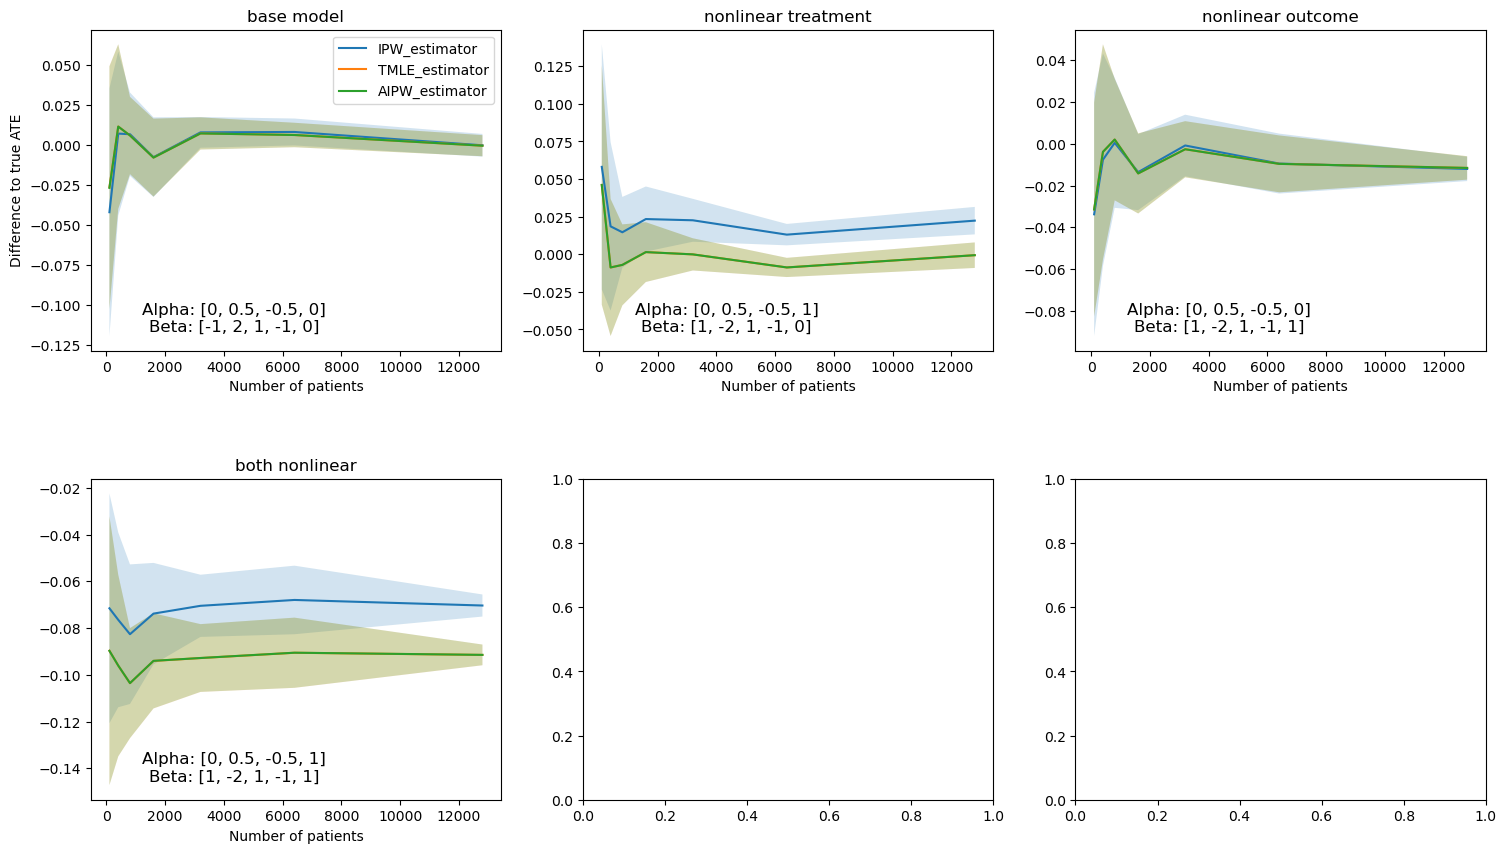

In [30]:
display_results(patient_numbers, models, diffs, stds, 'sample_std_estimator_comparison.png')

## Add bootstrap confidence intervals

In [42]:
# Helper function to compute and store results
estimators = [IPW_estimator, 
              TMLE_estimator, 
              AIPW_estimator]
patient_numbers = [200, 800, 3200, 12800]

models = {'base model':{'alpha': [0, 0.5, -0.5], 'beta': [-1, 2, 1, -1]},
          'change alpha':{'alpha': [-0.2, 1, -1], 'beta': [-1, 2, 1, -1]},
          'increase beta 1 ':{'alpha': [0, 0.5, -0.5], 'beta': [1, 5, 1, -1]},
          'flip beta 1':{'alpha': [0, 0.5, -0.5], 'beta': [1, -2, 1, -1]},
          'change beta': {'alpha': [0, 0.5, -0.5], 'beta': [.3, 1, -2, 1]},
          'new random model': {'alpha': [1, .5, 3], 'beta': [-1, 2, 1, -1]},
          }

diffs, stds = get_scores_for_models_and_estimators(patient_numbers, models, estimators, n_bootstraps=100)


 base model
n=200 n=800 n=3200 n=12800 
 change alpha
n=200 n=800 n=3200 n=12800 
 increase beta 1 
n=200 n=800 n=3200 n=12800 
 flip beta 1
n=200 n=800 n=3200 n=12800 
 change beta
n=200 n=800 n=3200 n=12800 
 new random model
n=200 n=800 n=3200 n=12800 

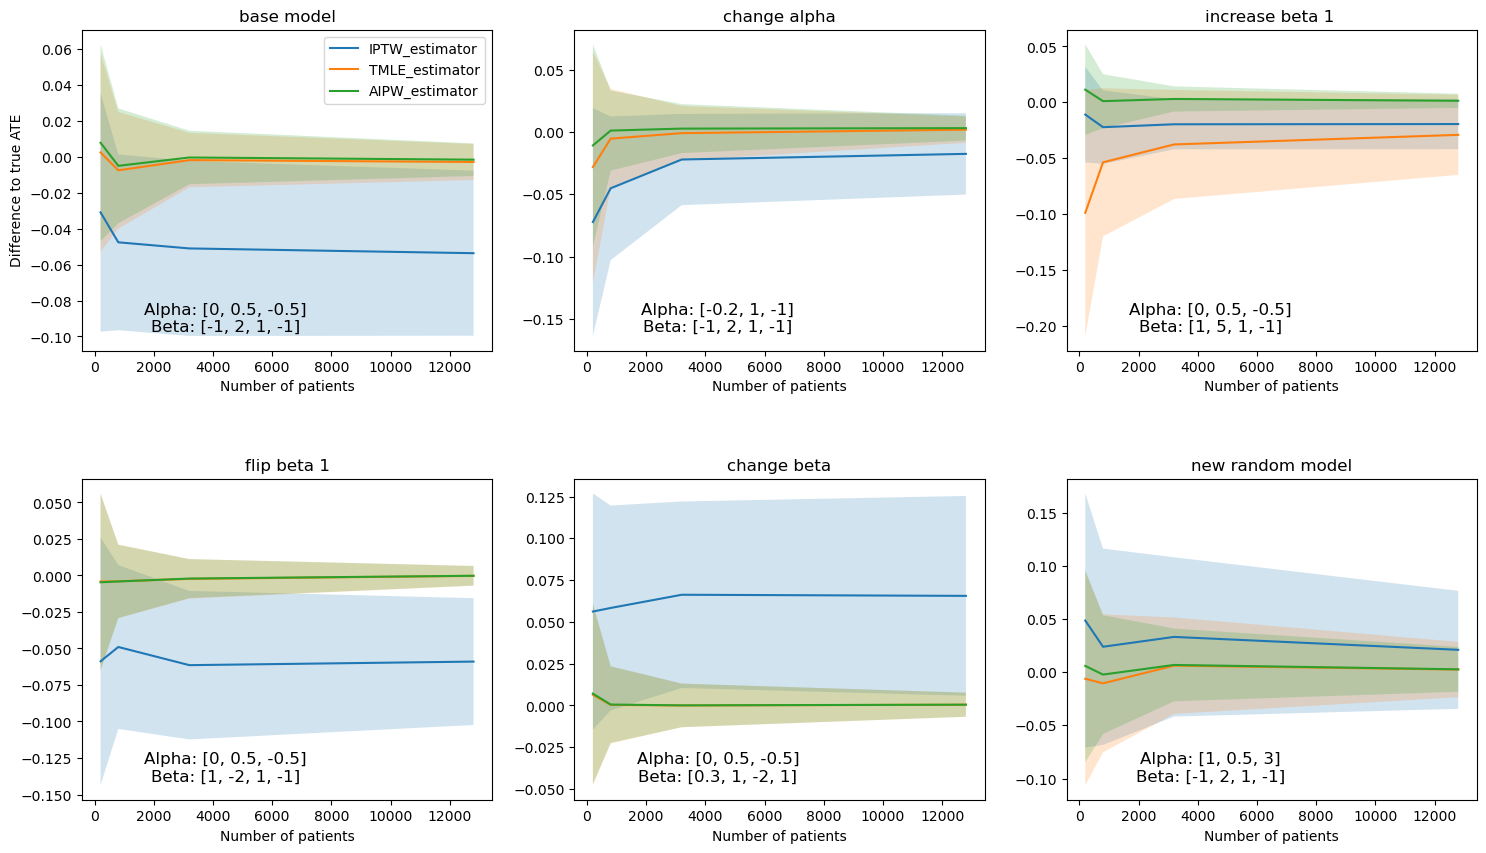

In [44]:
display_results(patient_numbers, models, diffs, stds, 'figures/bootstrap_estimator_comparison.png')